# Dataset loader and splitter

0. import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import json
import torch, torchvision
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import PIL 
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
import math
import nltk
import FlickrDataset
import Vocabulary
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import Image, display
import MyCollate

1. Load the Karpathy split set, create the needed split lists and append to the right variables

In [2]:
f = open('dataset_flickr30k.json')
dataset = json.load(f)

In [3]:
train_imgs = list()
man_woman_images = list()
train_labels = list()
val_imgs = list()
val_labels = list()
test_imgs = list()
test_labels = list()
all_labels = list()

In [4]:
from logging import error
import os, shutil

path = 'flickr/flickr30k_images/'
destinations = ['train', 'test', 'val']
for elem in destinations:
        if not os.path.exists(path+elem):
                os.makedirs(path+elem)
                
                
for img in dataset['images']:  
        tokenlist = []
        for sentence in img['sentences']:
                tokenlist.append(sentence['tokens'])
                                
        if img['split'] == 'train':
                
                train_imgs.append(img['filename'])
                train_labels.append(tokenlist)
                all_labels.append(tokenlist) 
                if 'man'  in tokenlist or 'woman' in tokenlist:
                        if img['filename'] not in man_woman_images:
                                man_woman_images.append(img['filename'])
                
        if img['split'] == 'test':
        
                test_imgs.append(img['filename'])
                test_labels.append(tokenlist)
                all_labels.append(tokenlist)
        
        if img['split'] == 'val':
                
                val_imgs.append(img['filename'])
                val_labels.append(tokenlist)
                all_labels.append(tokenlist)
        
                

Pour un premier essay des modeles de detection d'objets, nous allons créer un jeu de données contenant principalement les classes homme et femme. 

In [5]:
import random

random.shuffle(man_woman_images)

train_man_woman = man_woman_images[:100]
test_man_woman = man_woman_images[101:151]


In [6]:
dict_tokens = dict()
imgs_idx = dict()
idx_imgs = dict()
for idx, img in enumerate(dataset['images']):
    dict_tokens[idx] = [sentence['tokens'] for sentence in img['sentences']]   
    imgs_idx[img['filename']] = idx
    idx_imgs[idx] = img['filename']   

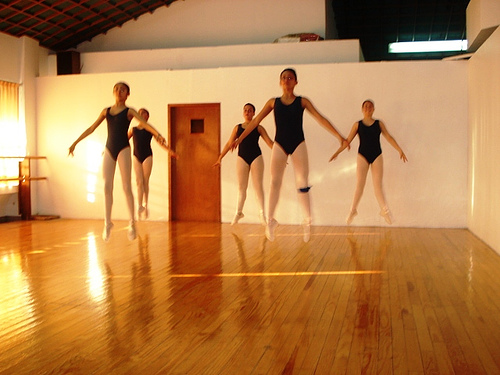

[['five', 'ballet', 'dancers', 'caught', 'mid', 'jump', 'in', 'a', 'dancing', 'studio', 'with', 'sunlight', 'coming', 'through', 'a', 'window'], ['ballet', 'dancers', 'in', 'a', 'studio', 'practice', 'jumping', 'with', 'wonderful', 'form'], ['five', 'girls', 'are', 'leaping', 'simultaneously', 'in', 'a', 'dance', 'practice', 'room'], ['five', 'girls', 'dancing', 'and', 'bending', 'feet', 'in', 'ballet', 'class'], ['a', 'ballet', 'class', 'of', 'five', 'girls', 'jumping', 'in', 'sequence']]


In [7]:
display(Image(filename=path + 'train/' + train_imgs[10]))
print(train_labels[10])

In [8]:
with open(path+'train/train.txt', 'w', encoding='utf-8') as f:
                        f.write('\n'.join(train_imgs))

with open(path+'train/man_woman.txt', 'w', encoding='utf-8') as f:
                        f.write('\n'.join(train_imgs))                      
with open(path+'test/test.txt', 'w', encoding='utf-8') as f:
                        f.write('\n'.join(test_imgs))
                        
with open(path+'val/val.txt', 'w', encoding='utf-8') as f:
                        f.write('\n'.join(val_imgs))

with open(path+'homme_femme/homme_femme_train.txt', 'w', encoding='utf-8') as f:
                        f.write('\n'.join(train_man_woman))

with open(path+'homme_femme/homme_femme_test.txt', 'w', encoding='utf-8') as f:
                        f.write('\n'.join(test_man_woman))

In [9]:
dict_tokens = dict()
imgs_idx = dict()
idx_imgs = dict()

for idx, img in enumerate(dataset['images']):
    dict_tokens[idx] = [sentence['tokens'] for sentence in img['sentences']]   
    imgs_idx[img['filename']] = idx
    idx_imgs[idx] = img['filename']

In [10]:
def get_loader(root_folder, 
               imgs, 
               labels,
               vocab,
               transforms, 
               imgs_idx,
               batch_size = 32, 
               shuffle=True
               ):
    dataset = FlickrDataset.FlickrDataset(root_folder, imgs, labels, vocab, transforms, imgs_idx)
    
    print('Dataset made!')
    
    loader = DataLoader(
        dataset = dataset,
        batch_size = batch_size,
        shuffle = shuffle,
        collate_fn = MyCollate.MyCollate(pad_idx = dataset.vocab.stoi["<PAD>"])
    )
    
    print('Loader made!')

    return loader, dataset

In [11]:
vocab = Vocabulary.Vocabulary(5)
vocab.build_vocabulary(all_labels)

Start building vocabulary!
Vocabulary built!


In [12]:
print('Lenght of the vocabulary: {}'.format(len(vocab)))

Lenght of the vocabulary: 7652


In [13]:
print('The most frequent word is: {}'.format(max(vocab.freq, key=vocab.freq.get)))

The most frequent word is: a


As expected, the most frequent word is a stopword. We will copy the frequencies dictionary without stopwords in a variable.

In [14]:
stopwords = nltk.corpus.stopwords.words('english')

vocab_no_stopwords = vocab.freq
to_delete = []
for key, value in vocab_no_stopwords.items():
    if key in stopwords:
        to_delete.append(key)
for word in to_delete:
    del vocab_no_stopwords[word]
    
print('The most frequent word is: {}'.format(max(vocab_no_stopwords, key=vocab_no_stopwords.get)))    

The most frequent word is: man


The most frequent 'object' is man. 

In [15]:
print(sorted(vocab_no_stopwords.items(), key=lambda item: item[1], reverse = True)[:20])

[('man', 41564), ('woman', 21582), ('two', 21100), ('people', 17024), ('wearing', 15373), ('shirt', 14083), ('white', 12971), ('young', 12857), ('black', 12131), ('blue', 11155), ('red', 10053), ('sitting', 9433), ('men', 9309), ('girl', 9209), ('boy', 8993), ('standing', 8852), ('dog', 8738), ('playing', 8450), ('street', 7861), ('group', 7733)]


In [16]:
vocab_no_stopwords.keys()
text = " ".join(x for x in vocab_no_stopwords.keys())
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

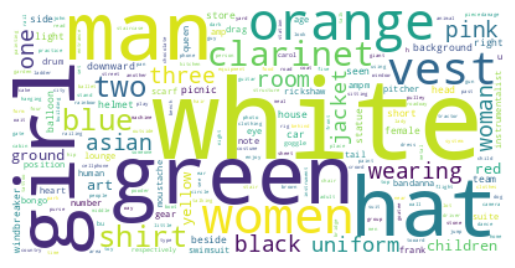

In [17]:
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Man and woman are the most common words. 

Let's create the data loader and the dataset

In [18]:
torch.manual_seed(17)
transformations_train = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
        ])
            
        
    

transformations_test = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
        ])


In [19]:
train_loader, train_dataset = get_loader(
        root_folder="flickr/flickr30k_images/train",
        imgs=train_imgs,
        labels=train_labels,
        vocab=vocab,
        transforms=transformations_train,
        batch_size=80,
        imgs_idx = imgs_idx
    )
val_loader, val_dataset = get_loader(
        root_folder="flickr/flickr30k_images/val",
        imgs=val_imgs,
        labels=val_labels,
        vocab=vocab,
        transforms=transformations_test,
        batch_size=80,
        imgs_idx = imgs_idx
    )

test_loader, test_dataset = get_loader(
        root_folder="flickr/flickr30k_images/test",
        imgs=test_imgs,
        labels=val_labels,
        vocab=vocab,
        transforms=transformations_test,
        batch_size=80,
        imgs_idx = imgs_idx
    )

Dataset made!


TypeError: 'list' object cannot be interpreted as an integer

In [ ]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

tensor_to_image(train_dataset[10][0][0])

NameError: name 'train_dataset' is not defined

Nous allons maintenant prendre notre jeu de données contenant que femme et homme et ajouter les bounding boxes

In [ ]:
import flickr30k_entities_utils as feu 

feu.get_sentence_data('annotations/Sentences/81641.txt')

[{'sentence': 'A man does acrobatics outside of a middle eastern style building .',
  'phrases': [{'first_word_index': 0,
    'phrase': 'A man',
    'phrase_id': '279867',
    'phrase_type': ['people']},
   {'first_word_index': 3,
    'phrase': 'acrobatics',
    'phrase_id': '279867',
    'phrase_type': ['other']},
   {'first_word_index': 6,
    'phrase': 'a middle eastern style building',
    'phrase_id': '279870',
    'phrase_type': ['scene']}]},
 {'sentence': 'A man is upside down on an outside gymnastics bar .',
  'phrases': [{'first_word_index': 0,
    'phrase': 'A man',
    'phrase_id': '279867',
    'phrase_type': ['people']},
   {'first_word_index': 6,
    'phrase': 'an outside gymnastics bar',
    'phrase_id': '279868',
    'phrase_type': ['scene']}]},
 {'sentence': 'The man is flipping over the bar .',
  'phrases': [{'first_word_index': 0,
    'phrase': 'The man',
    'phrase_id': '279867',
    'phrase_type': ['people']},
   {'first_word_index': 5,
    'phrase': 'the bar',
  

In [ ]:
feu.get_annotations('annotations/Annotations/81641.xml')


{'boxes': {'279867': [[86, 266, 228, 431]],
  '279868': [[167, 309, 226, 499]],
  '279870': [[1, 0, 360, 499]],
  '279871': [[169, 316, 209, 361]]},
 'scene': [],
 'nobox': [],
 'width': 375,
 'height': 500,
 'depth': 3}

## Encodeur pré-entrainé

In [1]:
import encoderCNN_pretrained
from feature_extractor import FeatureExtractor
from torchinfo import summary

enc = encoderCNN_pretrained.EncoderCNN()


/home/afrozilla/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/afrozilla/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                                  Param #
FasterRCNN                                              --
├─GeneralizedRCNNTransform: 1-1                         --
├─BackboneWithFPN: 1-2                                  --
│    └─IntermediateLayerGetter: 2-1                     --
│    │    └─Conv2d: 3-1                                 (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      --
│    │    └─ReLU: 3-3                                   --
│    │    └─MaxPool2d: 3-4                              --
│    │    └─Sequential: 3-5                             (212,992)
│    │    └─Sequential: 3-6                             1,212,416
│    │    └─Sequential: 3-7                             7,077,888
│    │    └─Sequential: 3-8                             14,942,208
│    └─FeaturePyramidNetwork: 2-2                       --
│    │    └─ModuleList: 3-9                             984,064
│    │    └─ModuleList: 3-10                            2,360,320
│    

In [65]:
summary(enc.model)

Layer (type:depth-idx)                                  Param #
FasterRCNN                                              --
├─GeneralizedRCNNTransform: 1-1                         --
├─BackboneWithFPN: 1-2                                  --
│    └─IntermediateLayerGetter: 2-1                     --
│    │    └─Conv2d: 3-1                                 (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      --
│    │    └─ReLU: 3-3                                   --
│    │    └─MaxPool2d: 3-4                              --
│    │    └─Sequential: 3-5                             (212,992)
│    │    └─Sequential: 3-6                             1,212,416
│    │    └─Sequential: 3-7                             7,077,888
│    │    └─Sequential: 3-8                             14,942,208
│    └─FeaturePyramidNetwork: 2-2                       --
│    │    └─ModuleList: 3-9                             984,064
│    │    └─ModuleList: 3-10                            2,360,320
│    

In [4]:
for name, layer in enc.model.named_modules():
    print(name)



transform
backbone
backbone.body
backbone.body.conv1
backbone.body.bn1
backbone.body.relu
backbone.body.maxpool
backbone.body.layer1
backbone.body.layer1.0
backbone.body.layer1.0.conv1
backbone.body.layer1.0.bn1
backbone.body.layer1.0.conv2
backbone.body.layer1.0.bn2
backbone.body.layer1.0.conv3
backbone.body.layer1.0.bn3
backbone.body.layer1.0.relu
backbone.body.layer1.0.downsample
backbone.body.layer1.0.downsample.0
backbone.body.layer1.0.downsample.1
backbone.body.layer1.1
backbone.body.layer1.1.conv1
backbone.body.layer1.1.bn1
backbone.body.layer1.1.conv2
backbone.body.layer1.1.bn2
backbone.body.layer1.1.conv3
backbone.body.layer1.1.bn3
backbone.body.layer1.1.relu
backbone.body.layer1.2
backbone.body.layer1.2.conv1
backbone.body.layer1.2.bn1
backbone.body.layer1.2.conv2
backbone.body.layer1.2.bn2
backbone.body.layer1.2.conv3
backbone.body.layer1.2.bn3
backbone.body.layer1.2.relu
backbone.body.layer2
backbone.body.layer2.0
backbone.body.layer2.0.conv1
backbone.body.layer2.0.bn1
bac

In [5]:
import torchvision
mod = torchvision.models.resnet50()
for name, layer in mod.named_modules():
    print(name)



conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.conv2
layer1.0.bn2
layer1.0.conv3
layer1.0.bn3
layer1.0.relu
layer1.0.downsample
layer1.0.downsample.0
layer1.0.downsample.1
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.conv2
layer1.1.bn2
layer1.1.conv3
layer1.1.bn3
layer1.1.relu
layer1.2
layer1.2.conv1
layer1.2.bn1
layer1.2.conv2
layer1.2.bn2
layer1.2.conv3
layer1.2.bn3
layer1.2.relu
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.conv2
layer2.0.bn2
layer2.0.conv3
layer2.0.bn3
layer2.0.relu
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.conv2
layer2.1.bn2
layer2.1.conv3
layer2.1.bn3
layer2.1.relu
layer2.2
layer2.2.conv1
layer2.2.bn1
layer2.2.conv2
layer2.2.bn2
layer2.2.conv3
layer2.2.bn3
layer2.2.relu
layer2.3
layer2.3.conv1
layer2.3.bn1
layer2.3.conv2
layer2.3.bn2
layer2.3.conv3
layer2.3.bn3
layer2.3.relu
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.conv2
layer3.0.bn2
layer3.0.conv

In [66]:
import cv2 
import matplotlib.pyplot as plt
def object_detection_api(img_path, threshold=0.9, rect_th=3, text_size=3, text_th=3): 
        imgT, boxes, pred_cls = enc.get_prediction(img_path, threshold)  # Get predictions 
        img = cv2.imread(img_path) # Read image with cv2 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB 
        for i in range(len(boxes)): 
            cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][0])), (int(boxes[i][1][0]), int(boxes[i][1][0])),color=(0, 255, 0), thickness=rect_th) 
            # Draw Rectangle with the coordinates 
            cv2.putText(img,pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][0])), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) 
            # Write the prediction class 
            plt.figure(figsize=(20,30)) 
        resnet_features = FeatureExtractor(enc.model, layers=['backbone.body.layer4', 'backbone.fpn', 'rpn', 'roi_heads.box_roi_pool', 'backbone.body.layer3', 'roi_heads', 'roi_heads.box_roi_pool', 'backbone'])
        features = resnet_features([imgT])
        # display the output image 
        plt.figure(figsize=(10,15))
        plt.imshow(img) 
        plt.xticks([]) 
        plt.yticks([])  
        plt.show()
        
        return features, boxes, pred_cls

<Figure size 2000x3000 with 0 Axes>

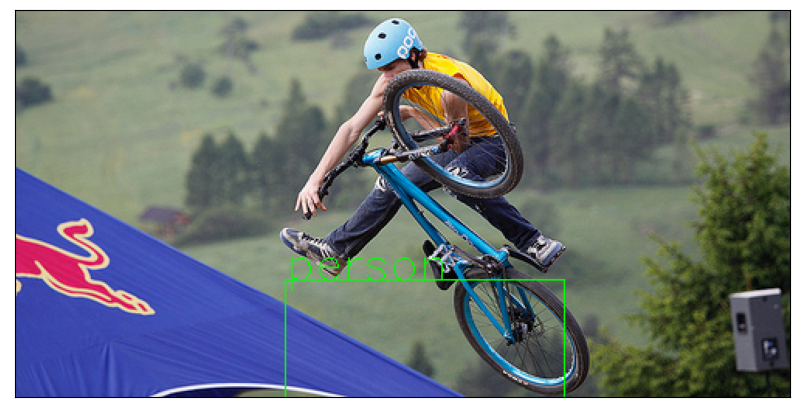

In [69]:
features, boxes, pred_cls = object_detection_api('flickr/flickr30k_images/val/7284553600.jpg', threshold = 0.9, rect_th=1, text_size=1, text_th=1 )

In [70]:
from torchvision import models
features['backbone.body.layer4'].size()

torch.Size([1, 2048, 21, 42])

In [71]:
features['roi_heads'][0][0]['boxes']

tensor([[174.9205,   5.5809, 354.2832, 187.6587],
        [175.8183,  48.5728, 370.5096, 241.9550],
        [186.5917,  73.5236, 345.3703, 175.5579],
        [253.9013, 129.9659, 369.5202, 246.2664],
        [  0.0000, 110.3452, 286.7981, 247.6323],
        [ 35.9959,  82.2892, 347.9006, 239.6949],
        [261.3236,  86.4273, 352.6506, 170.5146],
        [209.4188,  33.1757, 324.8946, 124.5911],
        [ 78.6814, 126.1431, 115.2958, 149.3713],
        [224.1548, 100.0046, 348.6837, 174.3414],
        [205.1091,  35.0552, 327.0654, 125.2311],
        [ 77.0382, 125.2020, 114.9743, 150.2811],
        [198.9270,   6.9590, 307.2281, 122.3344],
        [174.2213,  36.7919, 279.2849, 168.6992],
        [194.6402,  34.6750, 339.5571, 176.8652],
        [  3.8489, 106.5853, 268.3723, 248.4415],
        [ 87.7675, 240.3568, 213.4121, 249.8667],
        [ 87.7143, 240.4482, 212.9597, 249.6613],
        [214.5285,  99.9881, 352.8717, 227.0074]], grad_fn=<StackBackward0>)

In [64]:
features['backbone.fpn'][''].size()

torch.Size([1, 256, 13, 17])

In [126]:
boxes

[[(53.336525, 211.70982), (189.08585, 363.31348)],
 [(203.39767, 128.3905), (286.12576, 157.29152)],
 [(184.30847, 237.03862), (284.9629, 354.53183)],
 [(19.351887, 141.38075), (31.007357, 145.4491)]]

Voici le retour du modèle préentrainé. Nous ne sommes pas capables de faire de vrai estimations sans passer par le décodage pour verifier.

## Object detection model finetuning

In [ ]:
train_dataset[0]

(tensor([[[-2.0665, -2.0494, -2.0323,  ...,  1.1700,  1.6324,  1.6324],
          [-2.0665, -2.0323, -2.0494,  ...,  0.9988,  0.4851,  1.0844],
          [-2.0152, -2.0494, -2.0323,  ..., -0.9363, -0.9363, -0.3198],
          ...,
          [-0.7822, -0.4568, -0.5082,  ...,  0.2111,  0.2967,  0.1768],
          [-0.2342,  0.3138,  0.2282,  ...,  0.3823,  0.2111,  0.3481],
          [ 0.8104,  0.5364,  0.0741,  ...,  0.4851,  0.5364,  0.3138]],
 
         [[-1.9307, -1.9307, -1.9307,  ...,  1.9209,  2.2710,  2.3410],
          [-1.9657, -1.9307, -1.9307,  ...,  1.8158,  1.4132,  1.9909],
          [-1.8606, -1.9307, -1.9307,  ...,  0.1001,  0.1527,  0.8704],
          ...,
          [-0.2325, -0.1625, -0.2150,  ...,  1.1155,  1.0805,  0.9930],
          [ 0.2927,  0.8529,  0.9055,  ...,  1.1506,  0.9405,  1.1331],
          [ 1.2731,  1.2031,  1.0980,  ...,  1.0805,  1.2031,  0.9755]],
 
         [[-1.7173, -1.7173, -1.7173,  ...,  2.2391,  2.5180,  2.6051],
          [-1.7522, -1.7173,

In [ ]:
for i, data in enumerate(train_loader):
    print(i)
    print(data)
    break

NameError: name 'train_loader' is not defined

In [ ]:
def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.
    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)
                
def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """

    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)


In [ ]:
import AverageMeter
import time
from torch.nn.utils.rnn import pack_padded_sequence


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
alpha_c = 1.
grad_clip = 5.
log_step = 100


def train(train_loader, encoder, criterion, encoder_optimizer, epoch):
    
    encoder.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top5accs = AverageMeter()
    
    start = time.time()

    for i, (imgs, caps, caplens) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        imgs = encoder(imgs)

        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()

        if grad_clip is not None:
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)

        if encoder_optimizer is not None:
            encoder_optimizer.step()

        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % log_step == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Load Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(epoch, i, len(train_loader),
                                                                          batch_time=batch_time,
                                                                          data_time=data_time, loss=losses,
                                                                          top5=top5accs))

In [ ]:
def validate(val_loader, encoder, decoder, criterion):
    """
    Performs one epoch's validation.
    :param val_loader: DataLoader for validation data.
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :return: BLEU-4 score
    """
    decoder.eval()  # eval mode (no dropout or batchnorm)
    if encoder is not None:
        encoder.eval()

    batch_time = AverageMeter()
    losses = AverageMeter()
    top5accs = AverageMeter()

    start = time.time()

    references = list()  # references (true captions) for calculating BLEU-4 score
    hypotheses = list()  # hypotheses (predictions)

    # Batches
    for i, (imgs, caps, caplens, allcaps) in enumerate(val_loader):

        # Move to device, if available
        imgs = imgs.to(device)
        caps = caps.to(device)

        # Forward prop.
        if encoder is not None:
            imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas = decoder(imgs, caps, caplens)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]

        # Remove timesteps that we didn't decode at, or are pads
        # pack_padded_sequence is an easy trick to do this
        scores_copy = scores.clone()
        scores, _ = pack_padded_sequence(scores, decode_lengths, batch_first=True)
        targets, _ = pack_padded_sequence(targets, decode_lengths, batch_first=True)

        # Calculate loss
        loss = criterion(scores, targets)

        # Add doubly stochastic attention regularization
        loss += args.alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        # Keep track of metrics
        losses.update(loss.item(), sum(decode_lengths))
        top5 = accuracy(scores, targets, 5)
        top5accs.update(top5, sum(decode_lengths))
        batch_time.update(time.time() - start)

        start = time.time()

        if i % args.log_step == 0:
            print('Validation: [{0}/{1}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})\t'.format(i, len(val_loader), batch_time=batch_time,
                                                                            loss=losses, top5=top5accs))

        # Store references (true captions), and hypothesis (prediction) for each image
        # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
        # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]

        # References
        # allcaps = allcaps[sort_ind]  # because images were sorted in the decoder
        for j in range(allcaps.shape[0]):
            img_caps = allcaps[j].tolist()
            img_captions = list(
                map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<pad>']}],
                    img_caps))  # remove <start> and pads
            references.append(img_captions)

        # Hypotheses
        _, preds = torch.max(scores_copy, dim=2)
        preds = preds.tolist()
        temp_preds = list()
        for j, p in enumerate(preds):
            temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
        preds = temp_preds
        hypotheses.extend(preds)

        assert len(references) == len(hypotheses)

    # Calculate BLEU-4 scores
    bleu4 = corpus_bleu(references, hypotheses, emulate_multibleu=True)

    print(
        '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-4 - {bleu}\n'.format(
            loss=losses,
            top5=top5accs,
            bleu=bleu4))

    return bleu4

In [ ]:
def adjust_learning_rate(optimizer, shrink_factor):
    """
    Shrinks learning rate by a specified factor.
    :param optimizer: optimizer whose learning rate must be shrunk.
    :param shrink_factor: factor in interval (0, 1) to multiply learning rate with.
    """

    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))

In [ ]:
import time
fine_tune_encoder = True
encoder_lr = 1e-4
start_epoch = 0
epochs = 120
epochs_since_improvement = 0
encoder = encoderCNN_pretrained.EncoderCNN()
encoder_optimizer = torch.optim.SGD(encoder.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.lr_scheduler.StepLR(encoder_optimizer, step_size=7, gamma=0.1)
encoder = encoder.to(device)
criterion = nn.CrossEntropyLoss().to(device)

for epoch in range(start_epoch, epochs):
        if epochs_since_improvement == 20:
            break
        if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
            if fine_tune_encoder:
                adjust_learning_rate(encoder_optimizer, 0.8)

        train(train_loader=train_loader,
              encoder=encoder,
              criterion=criterion,
              encoder_optimizer=encoder_optimizer,
              epoch=epoch)

        recent_bleu4 = validate(val_loader=val_loader,
                                encoder=encoder,
                                criterion=criterion)

        is_best = recent_bleu4 > best_bleu4
        best_bleu4 = max(recent_bleu4, best_bleu4)
        if not is_best:
            args.epochs_since_improvement +=1
            print ("\nEpoch since last improvement: %d\n" %(args.epochs_since_improvement,))
        else:
            args.epochs_since_improvement = 0

        save_checkpoint(args.data_name, epoch, args.epochs_since_improvement, encoder, decoder, encoder_optimizer, decoder_optimizer,
                        recent_bleu4, is_best)



KeyboardInterrupt: 